# Starbucks - Capstone project

<br>
<br>

<img src='images/st02.png' width = 400>

<br>


# Modelling

Along our first script we have explored our data, adapting formats, making it look prettier, and extracting several new features in the process.

This first part was more the _"Data Engineering-like"_ part of the job.

In this second part, we will focus in our models:

# 1) Loading required packages and reading in the files

In [32]:
import pandas as pd
import numpy as np
import math
import json
import os
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [33]:
plt.rcParams['figure.figsize'] = [15, 5]

In [34]:
# read in the csv files created along our first script:

clean_profile_expanded = pd.read_csv('treated_data/clean_profile_expanded.csv', sep=';', )
total_matched_offers = pd.read_csv('treated_data/total_matched_offers.csv', sep=';')

# 2) Determining target variable and benchmark model

<img src='images/h2.JPG' width=600>

That has been a lot of trouble, but for a reason.

Now we have several features at our disposal in our clean_profile_expanded dataframe.

**GENERAL BENCHMARK:**
    
We will define the current success ratio rate as the following:

$SR = n_{offers sent}/n_{offers redeemed}$

The first benchmark for our model will be:

In [35]:
total_matched_offers['y'].sum()/total_matched_offers['y'].count()  

0.6098381609368245

So, at this moment, the massive emailing campaign is getting a success probability of about 61%.

## 3) Customer segmentation

We could see above a glance of the different success rates the offers have on the customers.

At this point, we want to remember that we decided to divide our users in highly succeptible to our offers, somewhat curious and those not at all interested.

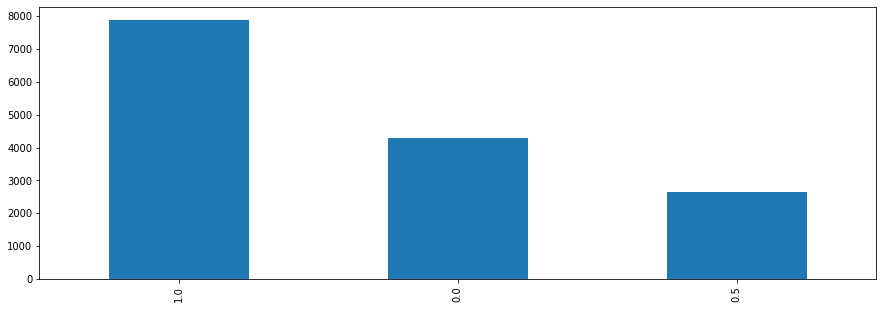

In [36]:
clean_profile_expanded['score'].value_counts().plot('bar');

We can see that, in general, our customer base responds well to our offers.

Also, the ammount of people we cannot decide whether are interested or not, does not constitute a big group.

Now, we are going to check the correlation of the rest of our variables with our target variable.

But, before, there are some characteristics that are not properly treated: indeed, sex, or group age have not been numerically defined, so there will be no information on their correlations, although we have seen in our exploration that these variables have an inpact on our target variable (the offer acceptance rate):

In [37]:
pos = len(clean_profile_expanded.columns) - 1

for col in ['gender', 'age_group']:
    col_dict = dict(clean_profile_expanded.groupby(col)['score'].mean())
    clean_profile_expanded.insert(pos, col+'_n', clean_profile_expanded[col].apply(lambda x: col_dict[x]))

age                    0.134886
income                 0.293226
year_bmo              -0.244421
month_bmo              0.031364
day_bmo               -0.004198
seniority              0.247225
tot_offers_received    0.037260
tot_am_spent           0.513247
mean_resp_t           -0.660342
max_resp_t            -0.632907
min_resp_t            -0.675990
nbr_pur                0.343184
tot_am_offers          0.386550
pur_interval          -0.257820
age_group_n            0.150874
gender_n               0.213288
score                  1.000000
Name: score, dtype: float64

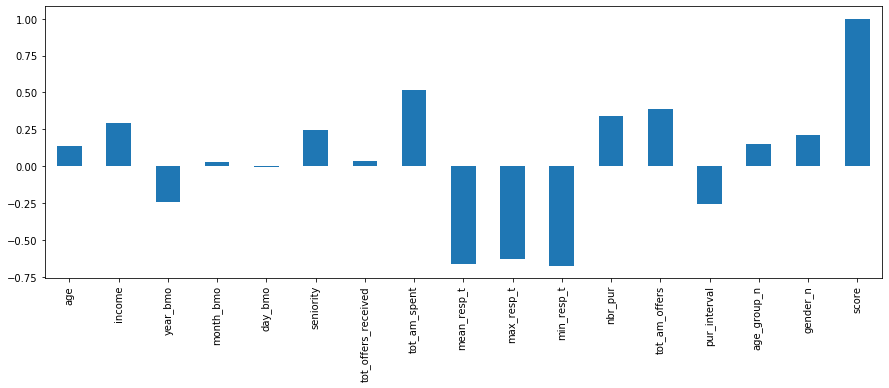

In [38]:
clean_profile_expanded.corr()['score'].plot('bar')
clean_profile_expanded.corr()['score']

We can see that we have several strong correlations, both positive and negative.

But also, we suspect many of our variables are intercorrelated. Particularly, the max, min and mean times of response to an offer should be heavily correlated among themselves.

Let's check it out:

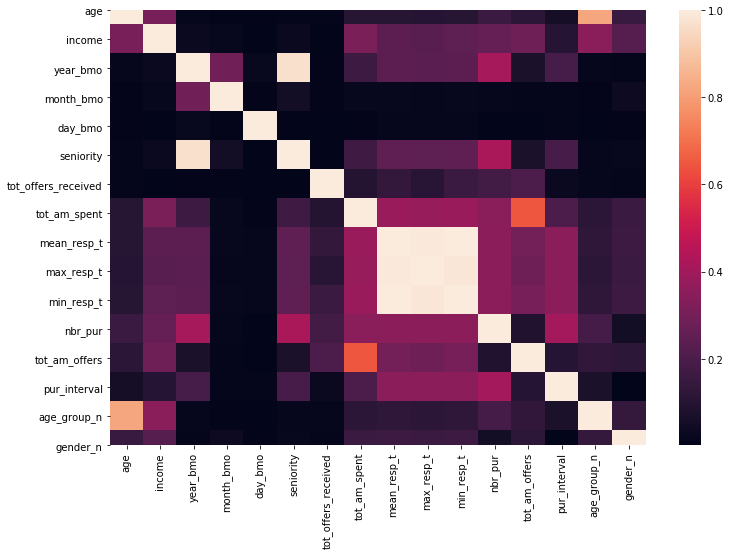

In [39]:
cust_feat_list = list(clean_profile_expanded.columns)
cust_feat_list.remove('score')

figure1 = plt.figure(figsize = (12,8))
cust_corr_matrix_df = clean_profile_expanded[cust_feat_list].corr()
sns.heatmap(cust_corr_matrix_df.abs())

We can see that we guessed correctly about the max, min and mean response times.

But we have also several other high correlations. We are going now to take a closer look, by signaling those correlations that trespass some threshold:

In [40]:
threshold = 0.4
cust_corr_matrix_df.apply(lambda x: list(set(x[x>threshold].index) - set([x.name])))                       

age                                [age_group_n]
income                                        []
year_bmo                                      []
month_bmo                                     []
day_bmo                                       []
seniority                              [nbr_pur]
tot_offers_received                           []
tot_am_spent                     [tot_am_offers]
mean_resp_t             [max_resp_t, min_resp_t]
max_resp_t             [mean_resp_t, min_resp_t]
min_resp_t             [mean_resp_t, max_resp_t]
nbr_pur                              [seniority]
tot_am_offers                     [tot_am_spent]
pur_interval                                  []
age_group_n                                [age]
gender_n                                      []
dtype: object

Appart from those stated above, we have also high correlations between:

**age - age_group_n**

We were expecting this one. Even when the relationship between these two values is not direct, the second is in some way derived from the first (we have grouped people by age and deducted their behavior from those groups).

We will drop the later.
    
**seniority - nbr_pur**

Seems reasonable that a certain correlation exists between the number of years a client has been registered, and the number of purchases the same client has performed. But both variables doesn't share a common origin that could lead us to suspect, both are derived from the same information. We will keep both.

**tot_am_spent - tot_am_offers**

These variables represent the money a client has spent in general, and the ammount the same client has spent on offers. As before, a certain level of correlation is expected but again, these two pieces of information don't share a common origin.

But, perhaps for this case, the substitution of one of the variables (or both) for some combination might be more insightful.
We will try:

tot_am_spent - tot_am_offers

tot_am_offers/tot_am_spent

In [41]:
clean_profile_expanded['non_offers_spent'] = clean_profile_expanded['tot_am_spent'] - clean_profile_expanded['tot_am_offers']
clean_profile_expanded['offers_spend_share'] = clean_profile_expanded['tot_am_offers'] / clean_profile_expanded['tot_am_spent']

In [42]:
corr_cols = ['tot_am_spent', 'tot_am_offers', 'non_offers_spent', 'offers_spend_share', 'score']
clean_profile_expanded[corr_cols].corr()

,tot_am_spent,tot_am_offers,non_offers_spent,offers_spend_share,score
tot_am_spent,1.000000,0.647433,0.801806,0.082266,0.513247
tot_am_offers,0.647433,1.000000,0.063683,0.444984,0.386550
non_offers_spent,0.801806,0.063683,1.000000,-0.242267,0.368981
offers_spend_share,0.082266,0.444984,-0.242267,1.000000,0.398587
score,0.513247,0.386550,0.368981,0.398587,1.000000


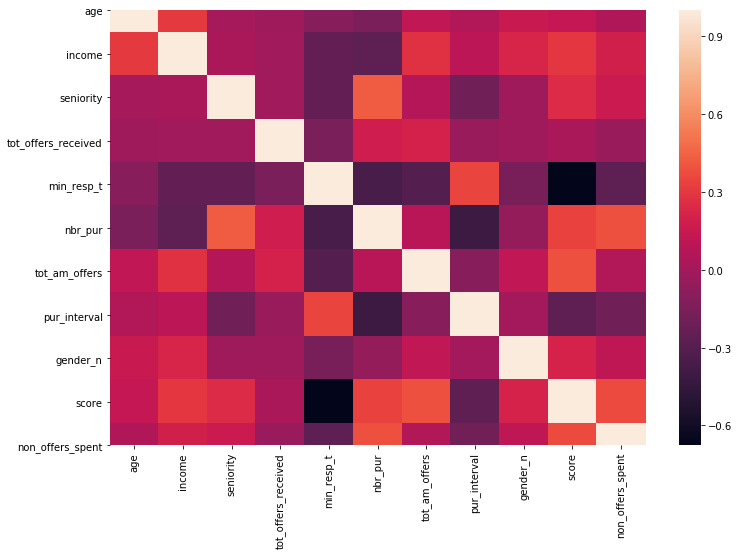

In [91]:
dr_cols = ['gender', 
           'date_bmo', 
           'year_bmo', 
           'month_bmo', 
           'day_bmo',
           'age_group',
           'mean_resp_t', 
           'max_resp_t', 
           'tot_am_spent', 
           'offers_spend_share',
           'age_group_n']

clean_profile_for_mod = clean_profile_expanded.drop(dr_cols, axis=1)

figure2 = plt.figure(figsize = (12,8))
sns.heatmap(clean_profile_for_mod.corr())

In [92]:
threshold = 0.4
clean_profile_for_mod.corr().apply(lambda x: list(set(x[x>threshold].index) - set([x.name])))

age                             []
income                          []
seniority                [nbr_pur]
tot_offers_received             []
min_resp_t                      []
nbr_pur                [seniority]
tot_am_offers                   []
pur_interval                    []
gender_n                        []
score                           []
non_offers_spent                []
dtype: object

# 4) Benchmark model

In [94]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [116]:
xy = clean_profile_for_mod[clean_profile_for_mod['score']!=0.5]
x = xy.drop(['id', 'score'], axis = 1)
y = xy['score']

In [117]:
lr = LinearRegression()
lr_fitted = lr.fit(x,y)
lr_fitted.coef_

array([ 9.01292670e-04,  2.25388517e-06,  3.72007988e-05, -3.63574461e-02,
       -4.72309026e-04,  1.22628548e-02,  9.27841157e-04,  4.29562839e-05,
        3.46073157e-01,  5.12899750e-04])

In [130]:
def bin_scoring_fun(x):
    
    if x>0.65:
        return 1
    else:
        return 0
    
y_hat = np.fromiter(map(scoring_fun, lr_fitted.predict(x)), dtype=np.int)

In [131]:
lr_cm = confusion_matrix(y, y_hat)
norm_lr_cm = lr_cm/lr_cm.sum()

In [132]:
norm_lr_cm

array([[0.28950612, 0.06245378],
       [0.01676391, 0.63127619]])

## AAAA

In [ ]:
x = clean_profile_for_mod.drop(['id', 'score'], axis = 1)
y = clean_profile_for_mod['score']

In [95]:
lr = LinearRegression()
lr_fitted = lr.fit(x,y)

In [97]:
lr_fitted.coef_

array([ 7.79394141e-04,  2.02735719e-06,  2.69005469e-05, -3.55278202e-02,
       -4.02479206e-04,  1.19969073e-02,  1.06774890e-03,  2.50085204e-05,
        3.35589156e-01,  5.84319190e-04])

In [98]:
def scoring_fun(x):
    
    if x>0.65:
        return 1
    elif x<0.35:
        return 0
    else:
        return 0.5
    
y_hat = np.fromiter(map(scoring_fun, lr_fitted.predict(x)), dtype=np.float)

In [99]:
y.value_counts()/y.value_counts().sum()

1.0    0.531939
0.0    0.288904
0.5    0.179157
Name: score, dtype: float64

In [100]:
lr_cm = confusion_matrix(2*y, 2*y_hat)
norm_lr_cm = lr_cm/lr_cm.sum()

In [101]:
norm_lr_cm

array([[0.17315346, 0.08317032, 0.0325801 ],
       [0.01996627, 0.05659359, 0.10259696],
       [0.        , 0.04006745, 0.49187184]])

In [102]:
np.matrix.trace(norm_lr_cm)

0.7216188870151771

In [107]:
norm_lr_cm_binary = norm_lr_cm[[0,2]]/norm_lr_cm[[0,2]].sum()
norm_lr_cm_binary

array([[0.21094585, 0.10132303, 0.03969102],
       [0.        , 0.04881256, 0.59922755]])

In [114]:
norm_lr_cm_binary[0][0] + norm_lr_cm_binary[1][2]

0.8101733914043883